# On Parcels
> An introductory article to Cryptovoxels' Parcel Data

- toc: true
- title: Parcels
- template: article
- description: this isnt working
- image: images/company_logo.png
- keywords: thisworks
- badges: true
- comments: true
- categories: [test]
- hide: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

I love freebies. In my opinion, guestbooks are the ticket to a bunch of em!

So what's the best way to find em all?

Perhaps the same way to find out a lot of really cool information... 🤔

## Parcel Data

In [1]:
#hide 
!pip install matplotlib
!pip install geopandas
!pip install folium

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


For starters CV provides generic data on ALL their [parcels](https://www.cryptovoxels.com/api/parcels/search.json)

In [2]:
#hide 
import requests
import json
url = 'https://www.cryptovoxels.com/api/parcels/search.json'
r = requests.get(url)
data = json.loads(r.text)['parcels'] 

In [3]:
#hide 
import pandas as pd
import geopandas as gpd
gdf = { "type": "FeatureCollection", "features": [] }
for obj in data:
  feat = { "type": "Feature", "geometry": { "type": "Polygon", "coordinates": [ ] }, "properties": { } }
  feat['geometry']['coordinates'] = obj['geometry']['coordinates'] 
  feat['properties'] = {key: obj[key] for key in obj if key not in ['x1','x2','y1','y2','z1','z2','geometry']}
  gdf['features'].append(feat)  

# What fresh hell have I done here?
with open('../data/cv.geojson', 'w') as outfile: json.dump(gdf, outfile)

gdf = gpd.read_file('../data/cv.geojson')
gdf['id'] = gdf.id.astype(str) 
gdf['vol'] = gdf['area'] * gdf['height'] 
gdf.to_file("../data/cv.geojson", driver='GeoJSON')

In [4]:
import folium
import branca
import branca.colormap as cm
from branca.colormap import linear

In [5]:
# https://stackoverflow.com/questions/54595931/show-different-pop-ups-for-different-polygons-in-a-geojson-folium-python-ma 
# https://python-visualization.github.io/branca/colormap.html 
"""
mymap = folium.Map(location=[0,0], tiles = 'https://map.cryptovoxels.com/tile?z={z}&x={x}&y={y}', attr="Map data &copy; Cryptovoxels", zoom_start=10, control_scale=True) 
colormap = cm.LinearColormap(colors=['white', 'blue','green', 'yellow', 'orange', 'red'], caption="Parcel Volume").to_step(data=gdf['vol'], method='quant', quantiles=[0,0.25,0.5,0.75,0.98, 0.999, 0.9999,1]) 
style_function = lambda x: {"weight":0.5, 'color':'black', 'fillColor':colormap(x['properties']['vol']), 'fillOpacity':0.75} 
highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1} 

layer = folium.FeatureGroup(name='your layer name', show=False) 
temp_geojson = folium.GeoJson(gdf) 
for feature in temp_geojson.data['features']: 
    innerHTML = '<b>'+str(feature['properties']['island'])+' - '+str(feature['properties']['suburb']) + '</b><br>' 
    innerHTML += '<b> Address - ' +str(feature['properties']['address']) + '</b><br>' 
    innerHTML += '<b> Height - ' +str(feature['properties']['height']) + '</b><br>' 
    innerHTML += '<b> Area - ' +str(feature['properties']['area']) + '</b><br>' 
    innerHTML += '<b> Volume - ' +str(feature['properties']['vol']) + '</b><br>' 
    temp_layer = folium.GeoJson(feature, style_function=style_function, highlight_function=highlight_function, tooltip=innerHTML) 
    foo = lambda txt, source: f`<div id="popupIFrame" style="white-space: nowrap;" align="center"> <a href="{source}"> Visit </a><br>{txt}</div>`
    folium.Popup( html=foo(innerHTML, f'https://www.cryptovoxels.com/parcels/{feature["properties"]["id"]}') ).add_to(temp_layer) 
    temp_layer.add_to(layer) 

layer.add_to(mymap) 
colormap.add_to(mymap) 
mymap.save('../docs/maps/cv_vol_map.html') 
"""

'\nmymap = folium.Map(location=[0,0], tiles = \'https://map.cryptovoxels.com/tile?z={z}&x={x}&y={y}\', attr="Map data &copy; Cryptovoxels", zoom_start=10, control_scale=True) \ncolormap = cm.LinearColormap(colors=[\'white\', \'blue\',\'green\', \'yellow\', \'orange\', \'red\'], caption="Parcel Volume").to_step(data=gdf[\'vol\'], method=\'quant\', quantiles=[0,0.25,0.5,0.75,0.98, 0.999, 0.9999,1]) \nstyle_function = lambda x: {"weight":0.5, \'color\':\'black\', \'fillColor\':colormap(x[\'properties\'][\'vol\']), \'fillOpacity\':0.75} \nhighlight_function = lambda x: {\'fillColor\': \'#000000\', \'color\':\'#000000\', \'fillOpacity\': 0.50, \'weight\': 0.1} \n\nlayer = folium.FeatureGroup(name=\'your layer name\', show=False) \ntemp_geojson = folium.GeoJson(gdf) \nfor feature in temp_geojson.data[\'features\']: \n    innerHTML = \'<b>\'+str(feature[\'properties\'][\'island\'])+\' - \'+str(feature[\'properties\'][\'suburb\']) + \'</b><br>\' \n    innerHTML += \'<b> Address - \' +str(featu

In [6]:
#hide 
# df = gdf[gdf['island'] == 'Scarcity'] # Only Scarcity Island 
# gdf[gdf['island']=='Scarcity']['island'].describe()
# gdf[gdf['island']=='Scarcity'].plot()

The data contains geocoordinates and a bit of meta data which can let us do fun stuff like this <a href="https://cvminigames.com/blog/docs/maps/cv_vol_map.html"> map </a>.

Where: 
- Color depicts volume broke out by quartile.

- And the top largest 2% and 1% of parcels painted orange and red, respectively.

In [7]:
%%html
<iframe height='500px' width='1000px' src="https://cvminigames.com/blog/docs/maps/cv_vol_map.html"/>

We can do other things like some light analysis. 

Here is a frequency plot of Flora Islands Volume (excluding it's outlier)

<AxesSubplot:ylabel='Frequency'>

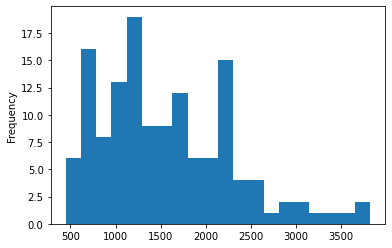

In [8]:
#hide_input 
t = gdf[gdf['island']=='Flora']
q_low = t["vol"].quantile(0.01)
q_hi  = t["vol"].quantile(0.99)
t = t[(t["vol"] < q_hi) & (t["vol"] > q_low)]
t['vol'].plot.hist(bins=20)

Ok. So thats nice...

I'll do more exploration on this end some time later...

What else can we do?

## Filtering Parcels

Information about a specific parcel is available by adding it's parcel # to the end of the following url: https://www.cryptovoxels.com/api/parcels/  

This data can then be filtered en-mass to search for certain properties, or inspected individually.

In [9]:
#hide
# This code will save each parcel features data

import requests
import json
t = """
deets = []
for index, row in df.tail(200).iterrows():
  url = 'https://www.cryptovoxels.com/api/parcels/'+str(row['id'])+'.json' 
  r = requests.get(url)
  data = json.loads(r.text) 
  with open('./parcels/'+str(row['id'])+'.json', 'w') as file:
    json.dump(data, file)
  print(row['id'])
"""

In [10]:
for index, row in gdf.head(200).iterrows():
  if index%50 == 0 : print(index)

0
50
100
150


In [11]:
! ls

000_core.ipynb	      001b_core_test.ipynb  002_Parcels.ipynb  _devserver.ipynb
001a_core_test.ipynb  001c_Example.ipynb    013_CV_Misc.ipynb  index.ipynb


In [12]:
gdf.head(1)

,id,height,address,suburb,island,name,area,distance,owner,owner_name,label,geometry,vol
0,6892,10,139b Min fir Road,Kauri,Flora,None,255,1792.612897,0xa253d7cd38dc2d0b2e65ad42a7e4beb3c60a83ad,crvox.eth,None,"POLYGON ((14.81000 10.10000, 14.81000 10.24990...",2550


In [13]:
import json
from shapely.geometry import Polygon
from os.path import exists
pd.options.display.max_colwidth = 500
deets = [] 

for index, row in gdf.iterrows():  
  url = '../data/parcels/'+str(row['id'])+'.json' 
  if not exists(url): continue
  data = ''  
  with open(url, 'r') as j: data = json.loads(j.read())['parcel'] 
  if data['content'] == None: continue 
  if 'features' not in data['content']: continue # SKIPS OVER PARCELS WITH NO FEATURES 
  newobj = {key: data[key] for key in data if key not in ['x1','x2','y1','y2','z1','z2','token','visible','geometry', 'streets', 'voxels', 'content', 'price', 'is_common']} 
  newobj['geometry'] = row['geometry'] 
  # Books
  guestbook = list(filter(lambda x: x['type'] == 'guest-book', data['content']['features'])) 
  if guestbook: newobj['book-position'] = guestbook[0]['position']

  deets.append( newobj )


In [14]:
# deets

In [15]:
test = pd.json_normalize(data=deets)
testgdf = gpd.GeoDataFrame(test, geometry='geometry', crs='epsg:3857') 

<AxesSubplot:>

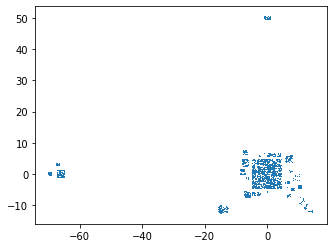

In [16]:
testgdf.plot()

For example we can search for parcels with guest-books!

In [17]:
#hide_input 
# testgdf[ ( testgdf['book-position'].notnull() ) ].drop(columns=['geometry'])[['link','book-position']].head(5)

In [18]:
testgdf.head(1)

,id,height,name,traffic_visits,address,area,distance,suburb,owner,owner_name,contributors,label,description,sandbox,lightmap_status,grid,island,kind,geometry,book-position
0,6748,6,None,NaN,31b Fault Line,95.919996,1849.130877,Bronze,0x09d06dcef22051477cde12cfbfc674f60a53c66c,None,"[0x690129B4a8fa04B5C5A81980816b1fE633356f56, 0xb7d3a787a39f25457ca511dc3f0591b546f5e02f]",None,None,False,None,False,Scarcity,unit,"POLYGON ((-14.740 -11.390, -14.740 -11.270, -14.660 -11.270, -14.660 -11.390, -14.740 -11.390))",NaN


In [19]:
ls

000_core.ipynb        001b_core_test.ipynb  002_Parcels.ipynb  _devserver.ipynb
001a_core_test.ipynb  001c_Example.ipynb    013_CV_Misc.ipynb  index.ipynb


In [20]:
testgdf.type()

In [ ]:
try:
  print("I will try to print this line of code")
  testgdf.to_file("../data/guest-books.geojson")
except Exception as e:
	print("ERROR : "+str(e))

I will try to print this line of code
ERROR : Invalid field type <class 'list'>
